In [1]:
import torch
import torchsde
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from plots import histogram
plt.style.use('dark_background')

# Heston Process

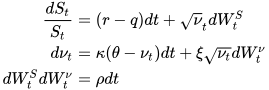

In [2]:
START = datetime(year=2004, month=9, day=1)
END = datetime(year=2024, month=9, day=1)
WINDOW_SIZE = 30

The idea is to train a model that learns to distinguish between
* real-world stock prices
* Heston-SDE paths

Each Heston-SDE path is associated with an $(r, q, \kappa, \theta, \xi, \rho)$ and therefore the model would implicitly give the likelihood of this tuple.

In [3]:
class Heston(torch.nn.Module):

    noise_type = "general"
    sde_type = "ito"
    state_size = 2
    brownian_size = 1

    def __init__(self, r=1e-4, kappa=2.0, theta=.01, xi=.1, q=.0, rho=.0, drift_limit=1):
        super().__init__()
        self.r = torch.nn.Parameter(torch.tensor(r), requires_grad=False)
        self.q = torch.nn.Parameter(torch.tensor(q), requires_grad=False)
        self.kappa = torch.nn.Parameter(torch.tensor(kappa), requires_grad=False)
        self.theta = torch.nn.Parameter(torch.tensor(theta), requires_grad=False)
        self.xi = torch.nn.Parameter(torch.tensor(xi), requires_grad=False)
        self.rho = torch.nn.Parameter(torch.tensor(rho), requires_grad=False)  # TODO
        self.drift_limit = drift_limit

    def f(self, t, y):
        multiplicator = torch.tensor([self.r - self.q, - self.kappa])
        drift = torch.mul(multiplicator, y)
        summand = torch.tensor([0, self.kappa * self.theta])
        drift += summand
        drift = torch.minimum(drift, self.drift_limit * torch.ones_like(drift))
        drift = torch.maximum(drift, - self.drift_limit * torch.ones_like(drift))
        return drift.view(y.shape[0], self.state_size)

    def g(self, t, y):
        diffusion_1 = torch.sqrt(y[:, -1])
        diffusion_2 = self.xi * torch.sqrt(y[:, -1])
        diffusion = torch.stack([diffusion_1, diffusion_2], dim=-1)
        return diffusion.view(y.shape[0], self.state_size, self.brownian_size)

[*********************100%***********************]  1 of 1 completed
/var/folders/vh/mv3ytp3x2_jg2tcq53sq9f240000gn/T/ipykernel_10805/3254398696.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y0 = torch.stack([real_trajectories[..., 0], torch.tensor(local_volatility)], dim=-1)


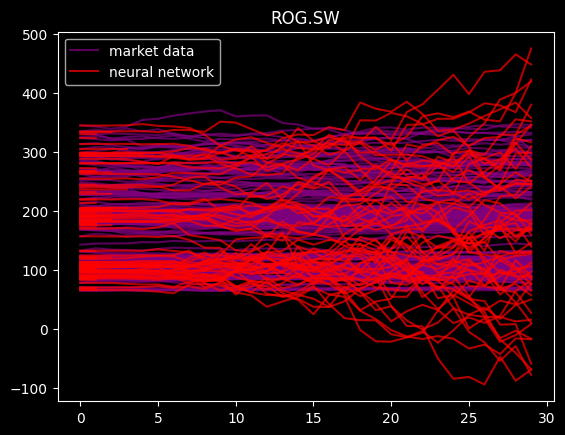

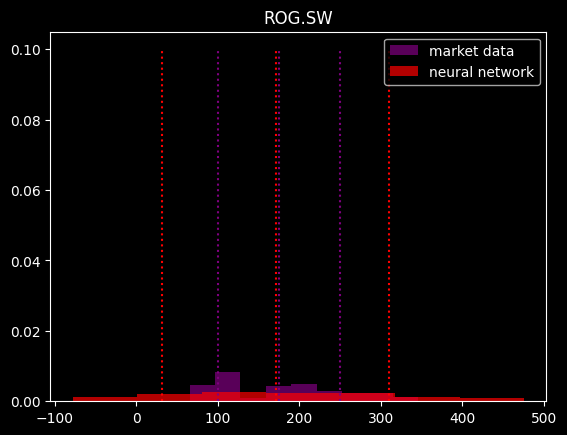

[*********************100%***********************]  1 of 1 completed
/var/folders/vh/mv3ytp3x2_jg2tcq53sq9f240000gn/T/ipykernel_10805/3254398696.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y0 = torch.stack([real_trajectories[..., 0], torch.tensor(local_volatility)], dim=-1)


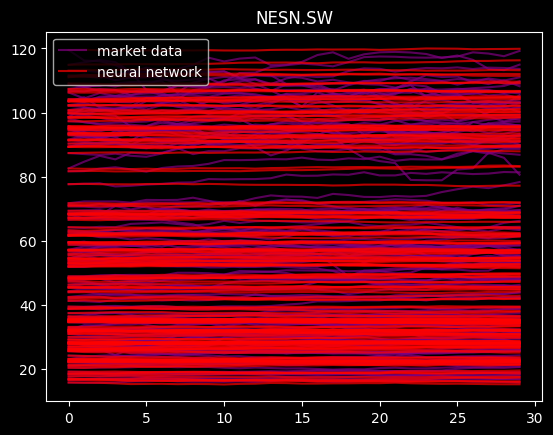

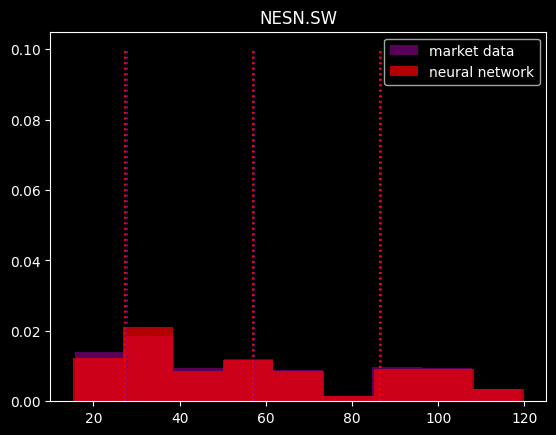

[*********************100%***********************]  1 of 1 completed
/var/folders/vh/mv3ytp3x2_jg2tcq53sq9f240000gn/T/ipykernel_10805/3254398696.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y0 = torch.stack([real_trajectories[..., 0], torch.tensor(local_volatility)], dim=-1)


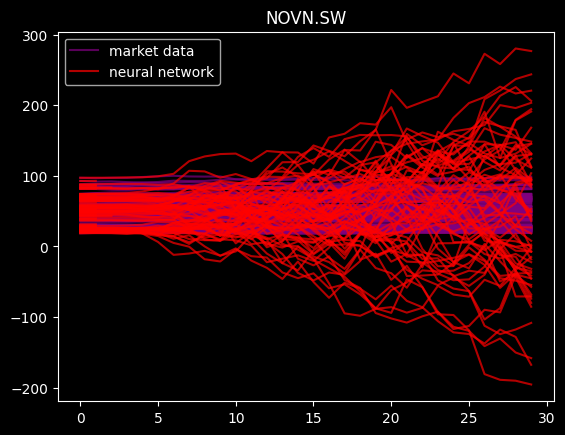

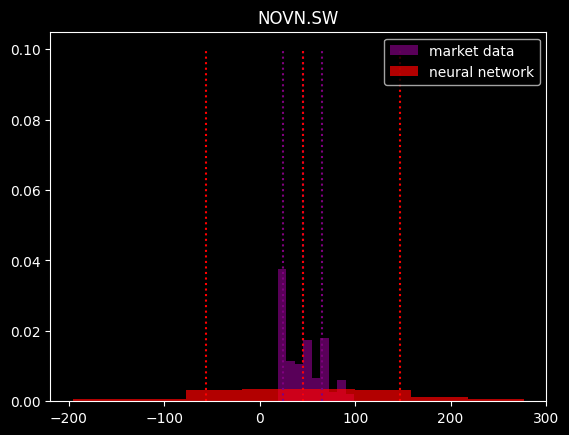

In [4]:
tickers = ["ROG.SW", "NESN.SW", "NOVN.SW"]  # pd.read_csv("bats_symbols.csv")["Name"]
parameter_names = ["r", "q", "theta", "xi", "kappa"]
for ticker in tickers:
    
    ticker_data = yf.download(ticker, start=START, end=END)
    real_trajectories = torch.tensor([window.to_list() for window in ticker_data["Adj Close"].rolling(WINDOW_SIZE) if len(window.to_list()) == WINDOW_SIZE][::WINDOW_SIZE], requires_grad=False)
    daily_return = ticker_data["Adj Close"].pct_change()
    local_volatility = daily_return.rolling(WINDOW_SIZE).std()[WINDOW_SIZE::WINDOW_SIZE]
    theta = local_volatility.mean()
    xi = local_volatility.std()
    drift_limit = 1000 * local_volatility.diff().max()
    kappa = (local_volatility.diff().iloc[1:] / (theta - local_volatility.iloc[:-1])).mean()

    sde = Heston(kappa=kappa, theta=theta, xi=xi, drift_limit=drift_limit)
    y0 = torch.stack([real_trajectories[..., 0], torch.tensor(local_volatility)], dim=-1)
    ts = torch.linspace(0.0, WINDOW_SIZE, WINDOW_SIZE)
    estimated_trajectories = torchsde.sdeint(sde=sde, y0=y0, ts=ts)[..., 0]

    for i, trajectory in enumerate(real_trajectories):
        plt.plot(trajectory, c="purple", alpha=.7, label="market data" if i == 0 else None)
    for i, trajectory in enumerate(estimated_trajectories.transpose(0, 1)):
        plt.plot(trajectory, c="red", alpha=.7, label="neural network" if i == 0 else None)
    plt.legend()
    plt.title(ticker)
    plt.show()

    real_terminal_state = real_trajectories[..., -1]
    histogram(real_terminal_state, label="market data", color="purple")
    estimated_terminal_state = estimated_trajectories[-1]
    histogram(estimated_terminal_state, label="neural network", color="red")
    plt.legend()
    plt.title(ticker)
    plt.show()